In [4]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [ ]:
class BicycleSolver:
    def __init__(self, m, a, b, C_alpha_f, C_alpha_r, I_z, u):
        self.a = a
        self.u = u
        self.A = np.array(
            [[-1 * (C_alpha_f + C_alpha_r) / (m * u), (-1 * (a * C_alpha_f - b * C_alpha_r) / (m * u)) - u],
            [-1 * (a * C_alpha_f - b * C_alpha_r) / (I_z * u), -1 * (a**2 * C_alpha_f + b**2 * C_alpha_r) / (I_z * u)]]
        ,dtype=np.float64)

        self.B = np.array(
            [[C_alpha_f / m],
            [a*C_alpha_f / I_z]]
        ,dtype=np.float64)

        self.A_4 = np.array(
            [
                [0,0,1,0],
                [0,0,0,1],
                [0,0,-1 * (C_alpha_f + C_alpha_r) / (m * u), (-1 * (a * C_alpha_f - b * C_alpha_r) / (m * u)) - u],
                [0,0,-1 * (a * C_alpha_f - b * C_alpha_r) / (I_z * u), -1 * (a**2 * C_alpha_f + b**2 * C_alpha_r) / (I_z * u)]
            ]
        ,dtype=np.float64)

        self.B_4 = np.array(
            [
                [0],
                [0],
                [C_alpha_f / m],
                [a*C_alpha_f / I_z]
            ]
        ,dtype=np.float64)
    
    def solve(self, iterator, func, init_vector: np.ndarray, init_t, max_iter: int, step_size: float, t_final=None):
        """
        Generalized iterative solver that solves Y' = func using the specified iteration method.
        """
        y = init_vector.copy()
        res = []

        t_values = np.linspace(init_t, init_t + max_iter * step_size, max_iter)
        if (t_final):
            t_values = np.linspace(init_t, t_final, max_iter)

        t = t_values[0]
        for i in range(len(t_values)):
            y = iterator(func, y, t, step_size)
            t = t_values[i]
            res.append(y)

        print(f"finished at t= {t}")
        return y, np.array(res)
    
    def check_stability(self):
        eigenvalues = np.linalg.eig(self.A).eigenvalues
        for eigenvalue in eigenvalues:
            if eigenvalue > 0:
                return False
        
        return True
        
    def ground_velocity(self, y_hist: np.ndarray):
        # Extract correct values for all trials
        yaw = y_hist[:, 1] /180 * np.pi    # Shape: (trials,)
        yaw_dot = y_hist[:, 3] / 180 * np.pi # Shape: (trials,)
        y_dot = y_hist[:, 2]   # Shape: (trials,)

        # Compute velocity components
        ground_velocity = np.stack([
            self.u * np.cos(yaw) - (y_dot + self.a * yaw_dot) * np.sin(yaw),
            (y_dot + self.a * yaw_dot) * np.cos(yaw) + self.u * np.sin(yaw)
        ], axis=1)        
        
        return ground_velocity
    
    def ground_position(self, ground_velocity : np.array, time_step : float, intial_pos = [0,0]):
        ground_position = deepcopy(ground_velocity)
        ground_position[0][0] = intial_pos[0] + ground_velocity[0][0] * time_step
        ground_position[0][1] = intial_pos[1] + ground_velocity[0][1] * time_step

        for i in range(1, ground_velocity.shape[0]):
            ground_position[i][0] = ground_position[i-1][0] + ground_velocity[i][0] * time_step
            ground_position[i][1] = ground_position[i-1][1] + ground_velocity[i][1] * time_step
        
        return ground_position
    
    @staticmethod
    def eulers_method(func, y_curr: np.ndarray, t, step_size: float) -> np.ndarray:
        """
        Euler's Method for n-dimensional systems.
        
        Args:
            func: F(Y, t). (n, 1) output shape
            y_curr: Y_i. (n, 1) shaped
            step_size: delta t. Scalar

        Returns:
            y_next: Y_i+1. (n, 1) shaped
        """
        y_next = y_curr + step_size * func(y_curr, t)

        return y_next

    @staticmethod
    def rk4(func, y_curr: np.ndarray, t, step_size: float) -> np.ndarray:
        k1: np.ndarray = func(y_curr, t)

        v2: np.ndarray = y_curr + step_size / 2 * k1
        k2: np.ndarray = func(v2, t + step_size / 2)

        v3: np.ndarray = y_curr + step_size / 2 * k2
        k3: np.ndarray = func(v3, t + step_size / 2)

        v4: np.ndarray = y_curr + step_size * k3
        k4: np.ndarray = func(v4, t + step_size)

        return y_curr + step_size / 6 * (k1 + 2*k2 + 2*k3 + k4)
    
    @staticmethod
    def bicycle_model(A, B, y, delta) ->np.ndarray:
        return np.matmul(A, y) + B*delta
    
    @staticmethod
    def target(t):
        """
        Helper Function to test solver. Taken from the project manual, this computes the solution for time t
        using init [0,0] and table parameters.
        """
        return np.array(
            [[-13.0964*np.e**(-1 * 1.9745 * t) + 24.468*np.e**(-1*0.9839*t) - 11.3720],
            [-0.2496*np.e**(-1 * 1.9745 * t) - 0.69262*np.e**(-1*0.9839*t) + 0.9457]]
        )
    
    def visualize_results(self, histories, labels, init_t, t_final, max_iter, title="", titleb=""):
        plt.close('all')
        plt.figure()
        for i, hist in enumerate(histories):
            t_values = np.linspace(init_t, t_final, max_iter)
            plt.plot(t_values, [val[0] for val in hist], label=labels[i])

        # Y accel
        plt.xlabel('Time (s)')
        plt.ylabel("Y Acceleration (m/s^2)")
        plt.legend()
        plt.grid()
        plt.title(title)
        plt.show()

        plt.figure()

        # Yaw Rate
        for i, hist in enumerate(histories):
            t_values = np.linspace(init_t, t_final, max_iter)
            plt.plot(t_values, [val[1] for val in hist], label=labels[i])

        plt.xlabel('Time (s)')
        plt.ylabel("Yaw Rate (rads/s^2)")
        plt.legend()
        plt.grid()
        if titleb:
            plt.title(titleb)
        else:
            plt.title(title)
        plt.show()
    
    def visualize_results2(self, histories, labels, init_t, t_final, max_iter, title=""):
        plt.close('all')
        plt.figure()
        for i, hist in enumerate(histories):
            t_values = np.linspace(init_t, t_final, max_iter)
            plt.plot(t_values, [val[0] for val in hist], label=labels[i])   
            

        # Y accel
        plt.xlabel('t')
        plt.ylabel("y accel")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid()
        plt.title(title)
        plt.show()
  # Yaw Rate
        for i, hist in enumerate(histories):
            t_values = np.linspace(init_t, t_final, max_iter)
            plt.plot(t_values, [val[1] for val in hist], label=labels[i])

        plt.xlabel('t')
        plt.ylabel("Yaw Rate")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid()
        plt.title(title)
        plt.show()


In [22]:
# Log Error vs. Log Grid Spacing Check
def const_delta(t):
    return 0.1



highly_exact_step_size = 0.0000001

init_vector = np.array([[0.0],[0.0]], dtype=np.float64)
t_final = 1
init_t = 0

euler_results = []
rk4_results = []

solver = BicycleSolver(
    m = 1400,
    a = 1.14,
    b = 1.33,
    C_alpha_f = 25000,
    C_alpha_r = 21000,
    I_z = 2420,
    u = 75 * 1000 / 3600
)

def task_a_model(y, t) -> np.ndarray:
    return solver.bicycle_model(solver.A, solver.B, y, const_delta(t))

max_iteration = int(t_final / highly_exact_step_size)
_, exact_sol = solver.solve(solver.rk4, task_a_model, init_vector, 0, max_iteration, highly_exact_step_size, t_final)


finished at t= 1.0


[-1. -2. -3.]
[np.float64(0.1), np.float64(0.01), np.float64(0.001)]
finished at t= 1.0
finished at t= 1.0
finished at t= 1.0
finished at t= 1.0
finished at t= 1.0
finished at t= 1.0


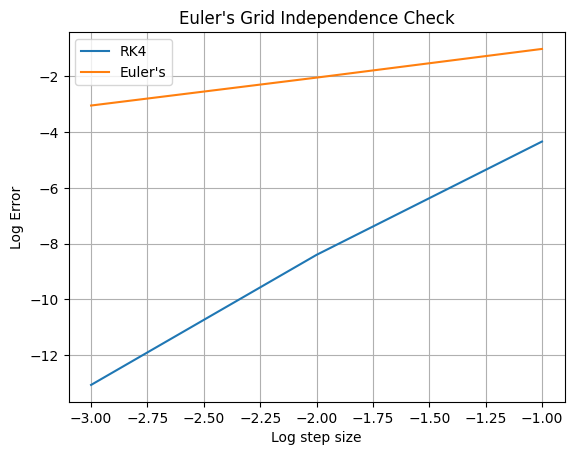

In [25]:
log_step_size = np.linspace(-1, -3, 3)
print(log_step_size)
grid_values = [np.power(10, i) for i in log_step_size]
print(grid_values)

for name, iterator in [("RK4", solver.rk4), ("Euler's", solver.eulers_method)]:
    log_error = []
    for step_size in grid_values:
        max_iteration = int(t_final / step_size)
        _, hist = solver.solve(iterator, task_a_model, init_vector, 0, max_iteration, step_size)
        # Compute log error
        target = exact_sol[-1] # we compute error on the last iteration
        error = target - hist[-1]
        log_error.append(np.log10(np.linalg.norm(error)))

    plt.plot(log_step_size, log_error, label=f"{name}")

plt.xlabel('Log step size')
plt.ylabel("Log Error")
plt.title(f"{name} Grid Independence Check")
plt.legend()
plt.grid()
plt.show()